# Exploration 16: Movie SBR
---

#### Model
* GRU4Rec

#### Data
* MovieLens 1M Dataset

#### Goals

1. data preprocessing
2. check train loss, Recall and MRR
3. try different hyperparameters to compare
---

#### Note

* UserID will be used as SessionID
* Do something with the `rating` data
* UTC time in `time` column

## Importing Dependencies

In [97]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# session time
from datetime import datetime

# model architecture
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print("All imported!")

All imported!


## Loading Data

In [40]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


---

## Data Pre-processing

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [42]:
# check missing value
data.isna().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

In [43]:
print(f'# of UserId: {data["UserId"].nunique()}')
print(f'# of ItemId: {data["ItemId"].nunique()}')
print(f'Rating Type: {data["Rating"].unique()}')

# of UserId: 6040
# of ItemId: 3706
Rating Type: [4 5 3 2 1]


#### Session Length

In [44]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [45]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [46]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [47]:
session_length.min(), session_length.max()

(20, 2314)

In [48]:
session_length.quantile(0.999)

1343.181000000005

99.9% of session_length is below 1343.181

In [49]:
long_session = session_length[session_length==2314].index[0]
print(long_session)

4169


In [50]:
data[data['UserId']==long_session].head(30)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


In [51]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

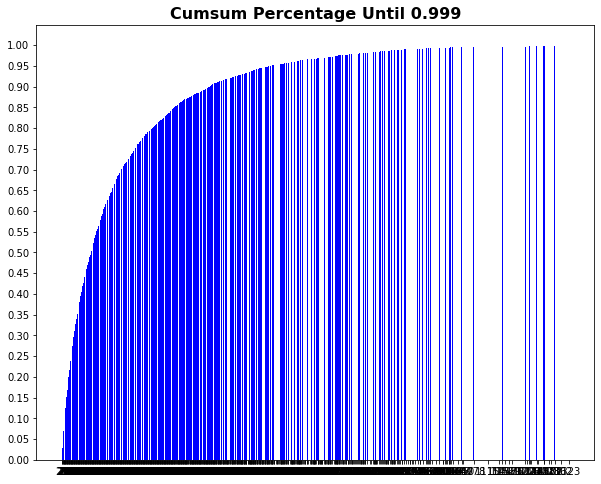

In [52]:
plt.figure(figsize=(10, 8))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=16, fontweight='bold')
plt.show()

In [53]:
session_length.quantile(0.95)

556.0

In [54]:
# removing outlier
drop_index = session_length[session_length>556].index
data.drop(index=drop_index, inplace=True)

#### Session time

In [56]:
def timestamp_convert(series_time):
    temp = series_time.copy()
    for i, v in enumerate(series_time):
        temp.iloc[i] = datetime.fromtimestamp(v)
    return temp

data['Time'] = timestamp_convert(data['Time'])
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [57]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [59]:
year_ago = latest - dt.timedelta(365*2)
data = data[data['Time'] > year_ago]
data.head(10)

,UserId,ItemId,Rating,Time
2327,19,318,4,2001-07-08 01:43:18
2492,19,1234,5,2001-07-08 01:43:56
2503,20,1694,3,2001-12-29 23:37:51
2512,20,1468,3,2001-12-29 23:37:51
2513,20,3717,2,2001-12-29 23:37:51
2517,20,2858,4,2001-12-29 23:37:51
2504,20,2641,4,2001-12-29 23:38:35
2510,20,1375,3,2001-12-29 23:38:35
2520,20,3753,5,2001-12-29 23:38:36
2511,20,1527,5,2001-12-29 23:39:41


#### Session ID

In [62]:
data = data.copy()

data['Time_diff'] = (data['Time'] - data['Time'].shift(1))
data['Time_diff'] = data['Time_diff'].fillna("0:0:0") # for first index, initialize

# index with more than 30 mins difference
timediff_idx = data.index[data['Time_diff']>'0:30:0']
UserId_idx = data.index[data['UserId'] != data['UserId'].shift(1)]

total_idx = list(timediff_idx.append(UserId_idx).unique())
all_idx = list(data.index)

value = 0
dic = {}
data['SessionId'] = 0

for i in all_idx:
    if i in total_idx:
        data.loc[i, 'SessionId'] = value
        value += 1
    else:
        data.loc[i, 'SessionId'] = value

data.head(20)

,UserId,ItemId,Rating,Time,Time_diff,SessionId
2327,19,318,4,2001-07-08 01:43:18,0 days 00:00:00,0
2492,19,1234,5,2001-07-08 01:43:56,0 days 00:00:38,1
2503,20,1694,3,2001-12-29 23:37:51,174 days 21:53:55,1
2512,20,1468,3,2001-12-29 23:37:51,0 days 00:00:00,2
2513,20,3717,2,2001-12-29 23:37:51,0 days 00:00:00,2
2517,20,2858,4,2001-12-29 23:37:51,0 days 00:00:00,2
2504,20,2641,4,2001-12-29 23:38:35,0 days 00:00:44,2
2510,20,1375,3,2001-12-29 23:38:35,0 days 00:00:00,2
2520,20,3753,5,2001-12-29 23:38:36,0 days 00:00:01,2
2511,20,1527,5,2001-12-29 23:39:41,0 days 00:01:05,2


#### Data Cleansing

In [63]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [66]:
data = cleanse_recursive(data, shortest=3, least_click=20)
data

,UserId,ItemId,Rating,Time,Time_diff,SessionId
2513,20,3717,2,2001-12-29 23:37:51,0 days 00:00:00,2
2517,20,2858,4,2001-12-29 23:37:51,0 days 00:00:00,2
2504,20,2641,4,2001-12-29 23:38:35,0 days 00:00:44,2
2510,20,1375,3,2001-12-29 23:38:35,0 days 00:00:00,2
2520,20,3753,5,2001-12-29 23:38:36,0 days 00:00:01,2
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,0 days 00:00:31,8863
999988,6040,1921,4,2001-08-10 14:41:04,0 days 00:00:35,8863
1000172,6040,1784,3,2001-08-10 14:41:04,0 days 00:00:00,8863
1000167,6040,161,3,2001-08-10 14:41:26,0 days 00:00:22,8863


In [67]:
data.drop('Time_diff', axis=1, inplace=True)
data

,UserId,ItemId,Rating,Time,SessionId
2513,20,3717,2,2001-12-29 23:37:51,2
2517,20,2858,4,2001-12-29 23:37:51,2
2504,20,2641,4,2001-12-29 23:38:35,2
2510,20,1375,3,2001-12-29 23:38:35,2
2520,20,3753,5,2001-12-29 23:38:36,2
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,8863
999988,6040,1921,4,2001-08-10 14:41:04,8863
1000172,6040,1784,3,2001-08-10 14:41:04,8863
1000167,6040,161,3,2001-08-10 14:41:26,8863


## Train/Valid/Test split

* train: 18 months
* valid: 4 months
* test: 2 months

In [68]:
data['Time'].max(), data['Time'].min()

(datetime.datetime(2003, 2, 28, 17, 49, 8),
 datetime.datetime(2001, 2, 28, 19, 7, 26))

In [69]:
test_time = data['Time'].max() - dt.timedelta(60)
test_time

datetime.datetime(2002, 12, 30, 17, 49, 8)

In [70]:
valid_time = test_time - dt.timedelta(120)
valid_time

datetime.datetime(2002, 9, 1, 17, 49, 8)

In [71]:
train_df = data[data['Time'] <= valid_time]
train_df

,UserId,ItemId,Rating,Time,SessionId
2513,20,3717,2,2001-12-29 23:37:51,2
2517,20,2858,4,2001-12-29 23:37:51,2
2504,20,2641,4,2001-12-29 23:38:35,2
2510,20,1375,3,2001-12-29 23:38:35,2
2520,20,3753,5,2001-12-29 23:38:36,2
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,8863
999988,6040,1921,4,2001-08-10 14:41:04,8863
1000172,6040,1784,3,2001-08-10 14:41:04,8863
1000167,6040,161,3,2001-08-10 14:41:26,8863


In [72]:
test_df = data[data['Time'] > test_time]
test_df

,UserId,ItemId,Rating,Time,SessionId
8704,59,2997,4,2003-01-07 18:02:48,13
8721,59,2147,2,2003-01-07 18:03:59,14
8781,59,2369,4,2003-01-07 18:04:24,14
8797,59,3408,4,2003-01-07 18:04:52,14
8808,59,2712,3,2003-01-07 18:04:52,14
...,...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57,8803
984682,5950,3578,4,2003-02-27 18:14:30,8803
984475,5950,3793,3,2003-02-27 18:15:10,8803
984660,5950,3555,2,2003-02-27 18:15:37,8803


In [73]:
temp_df = data[data['Time'] <= test_time]
val_df = temp_df[temp_df['Time'] > valid_time]
val_df

,UserId,ItemId,Rating,Time,SessionId
5184,36,2694,3,2002-12-22 08:08:14,12
5364,36,3786,4,2002-12-22 08:08:41,12
5262,36,2369,4,2002-12-22 08:09:24,12
5069,36,2713,1,2002-12-22 08:11:02,12
5280,36,3174,4,2002-12-22 08:11:25,12
...,...,...,...,...,...
959025,5787,441,4,2002-10-05 19:58:05,8711
958819,5787,3852,3,2002-10-05 19:58:29,8711
958987,5787,1297,3,2002-10-05 19:58:29,8711
959090,5787,2706,4,2002-10-05 19:58:29,8711


In [74]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [77]:
stats_info(train_df, 'Train')
stats_info(val_df, 'Valid')
stats_info(test_df, 'Test')

* Train Set Stats Info
	 Events: 39658
	 Sessions: 2432
	 Items: 1075
	 First Time : 2001-02-28 19:07:26
	 Last Time : 2002-09-01 00:14:13

* Valid Set Stats Info
	 Events: 3406
	 Sessions: 287
	 Items: 981
	 First Time : 2002-09-01 19:44:55
	 Last Time : 2002-12-30 16:47:52

* Test Set Stats Info
	 Events: 2167
	 Sessions: 157
	 Items: 892
	 First Time : 2002-12-30 19:40:24
	 Last Time : 2003-02-28 17:49:08



In [80]:
id2idx = {item_id : index for index, item_id in enumerate(train_df['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

train_df = indexing(train_df, id2idx)
val_df = indexing(val_df, id2idx)
test_df = indexing(test_df, id2idx)

In [81]:
data_path = Path('data')
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok = True)

train_df.to_pickle(save_path / 'train.pkl')
val_df.to_pickle(save_path / 'valid.pkl')
test_df.to_pickle(save_path / 'test.pkl')

## Data Pipeline
### Session-Parallel Mini-batch

#### Session Dataset

In [82]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [84]:
tr_dataset = SessionDataset(train_df)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
2513,20,3717,2,2001-12-29 23:37:51,2,0
2517,20,2858,4,2001-12-29 23:37:51,2,1
2504,20,2641,4,2001-12-29 23:38:35,2,2
2510,20,1375,3,2001-12-29 23:38:35,2,3
2520,20,3753,5,2001-12-29 23:38:36,2,4
2511,20,1527,5,2001-12-29 23:39:41,2,5
2523,20,1240,4,2001-12-29 23:39:41,2,6
2509,20,1371,4,2001-12-29 23:40:27,2,7
2671,22,1884,4,2001-05-29 15:10:55,2,8
2776,22,2376,3,2001-05-29 15:12:20,3,9


In [85]:
tr_dataset.click_offsets

array([    0,     9,    19, ..., 39633, 39639, 39658], dtype=int32)

In [86]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2429, 2430, 2431])

#### SessionDataLoader

In [87]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # session index for first batch
        last_session = self.batch_size - 1    # save session index
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]] # session begin
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session end
        mask = np.array([])   # add to mask if all session item has been used
        finished = False         # to check whether all data has been used
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # update status to generate the next batch dataset
        
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        
        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [88]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
2513,20,3717,2,2001-12-29 23:37:51,2,0
2517,20,2858,4,2001-12-29 23:37:51,2,1
2504,20,2641,4,2001-12-29 23:38:35,2,2
2510,20,1375,3,2001-12-29 23:38:35,2,3
2520,20,3753,5,2001-12-29 23:38:36,2,4
2511,20,1527,5,2001-12-29 23:39:41,2,5
2523,20,1240,4,2001-12-29 23:39:41,2,6
2509,20,1371,4,2001-12-29 23:40:27,2,7
2671,22,1884,4,2001-05-29 15:10:55,2,8
2776,22,2376,3,2001-05-29 15:12:20,3,9


In [89]:
iter_ex = iter(tr_data_loader)

In [92]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 1 10 20 41]
Label Item Idx are :       [ 2 11 21 42]
Previous Masked Input Idx are []


In [94]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 3 12 22 44]
Label Item Idx are :       [ 4 13 23 45]
Previous Masked Input Idx are [3]


## Model

#### Evaluation Metric

In [95]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture

In [98]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [101]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_df, val_df, test_df, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [102]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 1075)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      169050    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 1075)                54825     
Total params: 223,875
Trainable params: 223,875
Non-trainable params: 0
_________________________________________________________________


#### Model Training

In [103]:
# train with train data, evaluate with valid data
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU') # get gru_layer from model
    hidden_states = gru_layer.states[0].numpy()  # get parameter from gru_layer
    for elt in mask:
        hidden_states[elt, :] = 0  # parameter initialization
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  
                                             
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [104]:
train_model(model, args)

Evaluation:  70%|███████   | 68/97 [00:14<00:05,  4.84it/s]


	 - Recall@20 epoch 1: 0.046875
	 - MRR@20    epoch 1: 0.010009



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.06it/s]


	 - Recall@20 epoch 2: 0.067096
	 - MRR@20    epoch 2: 0.016889



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.04it/s]


	 - Recall@20 epoch 3: 0.094210
	 - MRR@20    epoch 3: 0.021727



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.16it/s]


	 - Recall@20 epoch 4: 0.109835
	 - MRR@20    epoch 4: 0.027445



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.21it/s]


	 - Recall@20 epoch 5: 0.127757
	 - MRR@20    epoch 5: 0.037036



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.09it/s]


	 - Recall@20 epoch 6: 0.142004
	 - MRR@20    epoch 6: 0.040462



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.08it/s]


	 - Recall@20 epoch 7: 0.155331
	 - MRR@20    epoch 7: 0.041094



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.23it/s]


	 - Recall@20 epoch 8: 0.154871
	 - MRR@20    epoch 8: 0.042967



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.19it/s]


	 - Recall@20 epoch 9: 0.154412
	 - MRR@20    epoch 9: 0.043562



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.22it/s]

	 - Recall@20 epoch 10: 0.152114
	 - MRR@20    epoch 10: 0.043057



#### second try
increased epochs to 20

In [105]:
args = Args(train_df, val_df, test_df, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 1075)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      169050    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 1075)                54825     
Total params: 223,875
Trainable params: 223,875
Non-trainable params: 0
_________________________________________________________________


In [106]:
train_model(model, args)

Evaluation:  70%|███████   | 68/97 [00:13<00:05,  4.97it/s]


	 - Recall@20 epoch 1: 0.042279
	 - MRR@20    epoch 1: 0.009465



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.12it/s]


	 - Recall@20 epoch 2: 0.057445
	 - MRR@20    epoch 2: 0.013242



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.13it/s]


	 - Recall@20 epoch 3: 0.084559
	 - MRR@20    epoch 3: 0.020829



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.15it/s]


	 - Recall@20 epoch 4: 0.108456
	 - MRR@20    epoch 4: 0.025676



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.20it/s]


	 - Recall@20 epoch 5: 0.129136
	 - MRR@20    epoch 5: 0.035002



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.23it/s]


	 - Recall@20 epoch 6: 0.140625
	 - MRR@20    epoch 6: 0.040181



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.22it/s]


	 - Recall@20 epoch 7: 0.154412
	 - MRR@20    epoch 7: 0.041790



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.27it/s]


	 - Recall@20 epoch 8: 0.161305
	 - MRR@20    epoch 8: 0.044657



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.15it/s]


	 - Recall@20 epoch 9: 0.164522
	 - MRR@20    epoch 9: 0.044743



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.24it/s]


	 - Recall@20 epoch 10: 0.157169
	 - MRR@20    epoch 10: 0.045066



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.35it/s]


	 - Recall@20 epoch 11: 0.152114
	 - MRR@20    epoch 11: 0.043999



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.33it/s]


	 - Recall@20 epoch 12: 0.154412
	 - MRR@20    epoch 12: 0.043656



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.30it/s]


	 - Recall@20 epoch 13: 0.153952
	 - MRR@20    epoch 13: 0.043273



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.26it/s]


	 - Recall@20 epoch 14: 0.149816
	 - MRR@20    epoch 14: 0.042912



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.35it/s]


	 - Recall@20 epoch 15: 0.152574
	 - MRR@20    epoch 15: 0.042512



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.34it/s]


	 - Recall@20 epoch 16: 0.153493
	 - MRR@20    epoch 16: 0.043977



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.23it/s]


	 - Recall@20 epoch 17: 0.151654
	 - MRR@20    epoch 17: 0.043269



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.12it/s]


	 - Recall@20 epoch 18: 0.150735
	 - MRR@20    epoch 18: 0.043134



Evaluation:  70%|███████   | 68/97 [00:12<00:05,  5.33it/s]


	 - Recall@20 epoch 19: 0.149816
	 - MRR@20    epoch 19: 0.042236



Evaluation:  70%|███████   | 68/97 [00:13<00:05,  5.05it/s]

	 - Recall@20 epoch 20: 0.147978
	 - MRR@20    epoch 20: 0.042156



#### third try
* epochs to 10
* batch_size to 16

In [107]:
args = Args(train_df, val_df, test_df, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(16, 1, 1075)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      169050    
_________________________________________________________________
dropout_2 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (16, 1075)                54825     
Total params: 223,875
Trainable params: 223,875
Non-trainable params: 0
_________________________________________________________________


In [108]:
train_model(model, args)

Evaluation:  84%|████████▎ | 162/194 [00:19<00:03,  8.32it/s]


	 - Recall@20 epoch 1: 0.057870
	 - MRR@20    epoch 1: 0.014398



Evaluation:  84%|████████▎ | 162/194 [00:18<00:03,  8.55it/s]


	 - Recall@20 epoch 2: 0.081404
	 - MRR@20    epoch 2: 0.018979



Evaluation:  84%|████████▎ | 162/194 [00:19<00:03,  8.20it/s]


	 - Recall@20 epoch 3: 0.109954
	 - MRR@20    epoch 3: 0.027009



Evaluation:  84%|████████▎ | 162/194 [00:19<00:03,  8.51it/s]


	 - Recall@20 epoch 4: 0.130787
	 - MRR@20    epoch 4: 0.034749



Evaluation:  84%|████████▎ | 162/194 [00:18<00:03,  8.59it/s]


	 - Recall@20 epoch 5: 0.140818
	 - MRR@20    epoch 5: 0.037091



Evaluation:  84%|████████▎ | 162/194 [00:18<00:03,  8.79it/s]


	 - Recall@20 epoch 6: 0.143133
	 - MRR@20    epoch 6: 0.038620



Evaluation:  84%|████████▎ | 162/194 [00:18<00:03,  8.74it/s]


	 - Recall@20 epoch 7: 0.148920
	 - MRR@20    epoch 7: 0.041491



Evaluation:  84%|████████▎ | 162/194 [00:18<00:03,  8.56it/s]


	 - Recall@20 epoch 8: 0.150077
	 - MRR@20    epoch 8: 0.041864



Evaluation:  84%|████████▎ | 162/194 [00:18<00:03,  8.80it/s]


	 - Recall@20 epoch 9: 0.149306
	 - MRR@20    epoch 9: 0.041822



Evaluation:  84%|████████▎ | 162/194 [00:18<00:03,  8.76it/s]

	 - Recall@20 epoch 10: 0.143904
	 - MRR@20    epoch 10: 0.041620



---

## Conclusion

Comparison<br/>

| <center>Trials</center> | <center>Recall</center> | <center>MRR</center> |
|:--------|--------:|--------:|
| first | 0.152114 | 0.043057 |
| second | 0.147978 | 0.042156 |
| third | 0.143904 | 0.041620 |

Unfortunately, changes were not that meaningful.<br/>
Maybe trying something different with time or ratings would have brought better results.<br/>
Fully understanding the SBR itself was challenging enough for this time.<br/>